In [3]:
from langgraph.graph import StateGraph,START,END
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from typing import TypedDict,Annotated
from pydantic import BaseModel,Field
import operator

In [4]:
load_dotenv()

True

In [5]:
model = ChatOpenAI(model = 'gpt-4o-mini')

In [6]:
class EvaluationSchema(BaseModel):
    
    feedback : str = Field(description= "Detailed Feedback for the Essay")
    score : int = Field(description= "Score Out of 10",ge=0,le=10)

In [7]:
structured_model = model.with_structured_output(EvaluationSchema)

In [8]:
essay = """
The Role of Artificial Intelligence in India

Artificial Intelligence (AI) has emerged as one of the most transformative technologies of the 21st century. In India, a country with a vast population and diverse challenges, AI is playing a crucial role in reshaping industries, improving governance, and driving economic growth. From healthcare to agriculture and education to public services, AI is opening new possibilities for innovation and development.

In governance, AI is helping the government provide faster and more efficient services to citizens. Chatbots and automated platforms are being used to handle public queries and grievances. AI-based systems are also being introduced for traffic management, crime prediction, and disaster response, making cities smarter and safer. Through initiatives like Digital India and the National AI Mission, the government is encouraging the adoption of AI in both public and private sectors.

Healthcare in India is another field where AI is showing a strong impact. AI-powered tools assist doctors in diagnosing diseases more accurately through medical imaging and predictive analytics. Rural areas, which often suffer from a shortage of doctors, are now benefiting from AI-driven telemedicine and mobile health solutions. The COVID-19 pandemic highlighted how AI could support contact tracing, vaccine research, and patient monitoring at a large scale.

Agriculture, the backbone of India’s economy, is also being modernized through AI. Farmers are using AI tools for crop monitoring, soil analysis, pest detection, and weather forecasting. These technologies allow them to make better decisions, improve crop yield, and reduce losses. AI-based applications are helping small farmers in rural India adopt smart farming practices that were earlier out of reach.

The education sector is equally benefiting from AI. EdTech platforms use AI to create personalized learning experiences for students, helping them learn at their own pace. Automated grading systems save time for teachers, while AI-powered translation tools make learning materials available in regional languages. This is helping bridge the gap between rural and urban education and making quality learning more accessible.

Economically, AI is strengthening industries such as banking, finance, manufacturing, and retail. Banks are using AI for fraud detection and customer support, while industries are adopting AI for automation, predictive maintenance, and data analysis. The startup ecosystem in India is also increasingly focused on AI-based solutions, contributing to job creation and innovation.

However, the growth of AI in India also comes with challenges. Issues of data privacy, security, and ethical use of AI remain important concerns. There is also a growing need to train the workforce in AI and related technologies so that India can fully harness its potential. Bridging the digital divide between rural and urban areas is another critical task for inclusive growth.

In conclusion, the role of AI in India is both promising and transformative. With government support, a young talent pool, and a growing digital infrastructure, India has the potential to become a global leader in AI. If developed responsibly and inclusively, AI can not only strengthen India’s economy but also improve the quality of life for millions of people across the country."""

In [9]:
prompt = f"Evaluate the language quality of the following essay and provide a feedback and assign a score out of 10 \n{essay}"
structured_model.invoke(prompt).score
structured_model.invoke(prompt).feedback

'The essay presents a well-structured analysis of the role of Artificial Intelligence (AI) in India, covering various sectors such as governance, healthcare, agriculture, education, and the economy. The language used is generally clear and coherent, with logical flow and appropriate use of technical vocabulary. However, there are areas for improvement:\n\n1. **Clarity and conciseness**: Some sentences are lengthy and could be more concise for better readability. For example, complex sentences like, "Through initiatives like Digital India and the National AI Mission, the government is encouraging the adoption of AI in both public and private sectors," could be simplified.\n\n2. **Variety of vocabulary**: While the essay contains relevant terminology, there is a slight repetitiveness in phrases like "AI is..." and "AI-powered...". Incorporating synonyms or rephrasing could enhance the linguistic richness.\n\n3. **Depth of analysis**: While the essay does a good job of outlining applicati

In [10]:
class UPSCState(TypedDict):
    essay: str
    language_feedback: str
    analysis_feedback: str
    clarity_feedback : str
    overall_feedback : str
    individual_scores : Annotated[list[int],operator.add]
    avg_score: float

In [11]:
def evaluate_language(state:UPSCState):
    prompt = f"Evaluate the language quality of the following essay and provide a feedback and assign a score out of 10 \n {state['essay']}"
    output = structured_model.invoke(prompt)
    
    return {'language_feedback':output.feedback,'individual_scores':[output.score]}


In [12]:
def  evaluate_analysis(state:UPSCState):
    
    prompt= f"Evaluate the depth of analysis of the following essay and provide a feedback and assign a score out of 1 \n {state['essay']}"
    output= structured_model.invoke(prompt)
    
    return {'analysis_feedback': output.feedback,'individual_scores':[output.score]}


In [13]:
def final_evaluation(state:UPSCState):
    
    # summary feedback
    prompt = f"Based on the following feedback create a summarized feedback \n language feedback - {state['language_feedback']} \n depth of analysis feedback - {state['analysis_feedback']} \n clarity of thought feedback - {state['clarity_feedback']}"
    overall_feedback = model.invoke(prompt).content
    
    # avg_score 
    avg_score = sum(state['individual_scores'])/len(state['individual_scores'])
    
    return{'overall_feedback': overall_feedback,'avg_score':avg_score}

In [14]:
def evaluate_thought(state : UPSCState):
    
    prompt = f"Evaluate the clarity of thought of the following essay and provide a feedback and assign a score out of 10 \n {state['essay']}"
    output = structured_model.invoke(prompt) 
    
    return {'clarity_feedback': output.feedback,'individual_scores':[output.score]}


In [15]:
graph = StateGraph(UPSCState)
graph.add_node('evaluate_language',evaluate_language)
graph.add_node('evaluate_analysis',evaluate_analysis)
graph.add_node('evaluate_thought',evaluate_thought)
graph.add_node('final_evaluation',final_evaluation)

# edges
graph.add_edge(START,'evaluate_language')
graph.add_edge(START,'evaluate_analysis')
graph.add_edge(START,'evaluate_thought')

graph.add_edge('evaluate_language','final_evaluation')
graph.add_edge('evaluate_analysis','final_evaluation')
graph.add_edge('evaluate_thought','final_evaluation')

graph.add_edge('final_evaluation',END)

workflow = graph.compile()

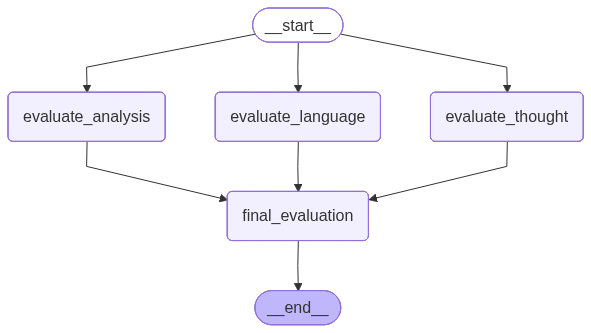

In [16]:
workflow

In [17]:
initial_state = {
    'essay' : essay
}

workflow.invoke(initial_state)

{'essay': '\nThe Role of Artificial Intelligence in India\n\nArtificial Intelligence (AI) has emerged as one of the most transformative technologies of the 21st century. In India, a country with a vast population and diverse challenges, AI is playing a crucial role in reshaping industries, improving governance, and driving economic growth. From healthcare to agriculture and education to public services, AI is opening new possibilities for innovation and development.\n\nIn governance, AI is helping the government provide faster and more efficient services to citizens. Chatbots and automated platforms are being used to handle public queries and grievances. AI-based systems are also being introduced for traffic management, crime prediction, and disaster response, making cities smarter and safer. Through initiatives like Digital India and the National AI Mission, the government is encouraging the adoption of AI in both public and private sectors.\n\nHealthcare in India is another field whe

In [18]:
essay2 = """
Artificial Intelligence is changing India in many ways and its role is getting bigger every day it helps people in citys and villages, but sometimes it also causes problems. In government jobs AI is used for quick replies and to reduce work load, many websites have chatbots which answers citizen questions fast but they are not always correct. In health care AI helps doctors to look at x rays and find problems earlier which is good for patients, and some apps try to give medical advice to people in remote areas though this is not the same as a real doctor so it can be risky. Farmers also get help from AI, there are apps that tell when to water or spray pesticide and they can increase crop yield, however many farmers cannot use smartphones or they dont trust the apps so adoption is slow.

In schools AI is used to create lessons that adapt to each student which makes learning easier, but some teachers feel replaced and worry about job security. Business and banks use AI for fraud detection and customer service and this saves money and time, while industries use robots and machines for faster production. Yet these changes sometimes lead to job losses and people need to learn new skills quickly or they will be left behind. Privacy is another issue because AI systems often collect lots of personal data and there are not enough strong laws to protect everyone. Also AI systems can make biased decisions because they are trained on old data which contains human mistakes.

Overall AI can bring many benefits to India and help improve life for millions, but it is not perfect and cant solve every problem by itself. If government, companies and people work together, and teach workers new skills, AI will be more useful and safer, but we must be careful and check systems often so things dont go wrong."""

In [19]:
initial_state = {
    'essay' : essay2
}

workflow.invoke(initial_state)

{'essay': '\nArtificial Intelligence is changing India in many ways and its role is getting bigger every day it helps people in citys and villages, but sometimes it also causes problems. In government jobs AI is used for quick replies and to reduce work load, many websites have chatbots which answers citizen questions fast but they are not always correct. In health care AI helps doctors to look at x rays and find problems earlier which is good for patients, and some apps try to give medical advice to people in remote areas though this is not the same as a real doctor so it can be risky. Farmers also get help from AI, there are apps that tell when to water or spray pesticide and they can increase crop yield, however many farmers cannot use smartphones or they dont trust the apps so adoption is slow.\n\nIn schools AI is used to create lessons that adapt to each student which makes learning easier, but some teachers feel replaced and worry about job security. Business and banks use AI for

In [20]:
essay3 = """
The Role of Artificial Inteligence in India

Artificial Inteligence (AI) is very popular now a days in India. Many pepole say it will change the future completly and make life very easy, but some also fear it will take all jobs away. India being a large country with too many pepole need such technologies to manage things like health, educashun and even traffic jams on the road.

In the goverment sector AI is already used for many things like online forms, chat boots and auto reply systems. For example, if a citizen ask a qustion on a portal, a machine can answer it faster then a human. But sometimes the bots just give wrong ansers which makes people angry. Also AI is used in CCTV cameras to catch crimminals. I also think AI can be used for making cricket teams stronger because India loves cricket so much.

In helthcare AI helps doctors to read x-rays and MRI scan very quikly. This is very usefull because in villages there are not enough doctors. During Covid-19 pandamic AI was used for tracking pepole but some said it was a privacy voilation. At the same time, AI can also be used in gyms to create diet plans for bodybuilders which is not really the same as healthcare but still it helps.

Agriculture is another field where AI is impotrant. Farmers use apps for crop monitering, soil testing and weather prediction. But many farmers dont have smartfones or internet so it is hard to use. Some farmers also believe AI can control rain which is not true.

In educashun, AI is used to make personal learning plans for students. It can even translate english into hindi or tamil so students understand better. But some students just use ChatGPT or other bots to do homework which is cheeting.

In conclushun, AI in India has many benifits but also many problums. It can improve services, help doctors, and support farmers, but it also brings job lose and privacy risks. Still, if goverment, teachers, and even sports players work together AI will become more helpfull for the country."""

In [21]:
initial_state = {
    'essay':essay3
}
workflow.invoke(initial_state)

{'essay': '\nThe Role of Artificial Inteligence in India\n\nArtificial Inteligence (AI) is very popular now a days in India. Many pepole say it will change the future completly and make life very easy, but some also fear it will take all jobs away. India being a large country with too many pepole need such technologies to manage things like health, educashun and even traffic jams on the road.\n\nIn the goverment sector AI is already used for many things like online forms, chat boots and auto reply systems. For example, if a citizen ask a qustion on a portal, a machine can answer it faster then a human. But sometimes the bots just give wrong ansers which makes people angry. Also AI is used in CCTV cameras to catch crimminals. I also think AI can be used for making cricket teams stronger because India loves cricket so much.\n\nIn helthcare AI helps doctors to read x-rays and MRI scan very quikly. This is very usefull because in villages there are not enough doctors. During Covid-19 panda

In [24]:
essay4= """
Artificial Intelligence and India’s Developmental State

Artificial Intelligence (AI) marks a decisive shift in the relationship between the State, technology, and society. For India, a nation grappling simultaneously with scale, inequality, and governance deficits, AI is not merely a tool of efficiency but a test of democratic capacity. Its adoption will determine whether technology deepens exclusion or becomes an instrument of inclusive, constitutional development.

In governance, AI has the potential to significantly enhance state capacity. Predictive analytics is increasingly used in tax administration to identify evasion, while algorithmic tools assist in grievance redressal, welfare targeting, and urban management. Such applications promise efficiency, reduced leakages, and evidence-based policymaking—long-standing challenges in India’s administrative machinery. In this sense, AI aligns with the constitutional values of transparency and accountability by strengthening the State’s ability to deliver public goods.

However, algorithm-driven governance also raises critical concerns. Automated decision-making risks opacity, dilution of administrative discretion, and erosion of due process. Biased datasets can reproduce social hierarchies, undermining Article 14’s guarantee of equality before law. As the State increasingly relies on algorithms, the principle of reasoned decision-making—central to administrative justice—must not be sacrificed at the altar of efficiency.

The healthcare sector demonstrates AI’s transformative potential when guided by public purpose. AI-assisted diagnostics in tuberculosis screening, cancer detection, and medical imaging have expanded access in underserved regions. Telemedicine platforms supported by AI help bridge the rural–urban divide, advancing the constitutional promise of the right to life under Article 21. Yet, the unequal distribution of digital infrastructure and skilled manpower risks creating a two-tier healthcare system, highlighting the need for state-led intervention.

Agriculture, employing nearly half of India’s workforce, presents another critical frontier. AI-powered tools for crop monitoring, weather forecasting, and soil analysis enable precision farming, improving productivity and climate resilience. These technologies support the goals of income security and sustainable agriculture, in line with the Directive Principles of State Policy. Nevertheless, small and marginal farmers often lack access to capital, data, and digital literacy, raising concerns that technological gains may disproportionately benefit large agribusinesses.

AI’s impact on education and employment further reflects this duality. Adaptive learning platforms can personalize education, address learning gaps, and improve outcomes in a diverse population. Simultaneously, automation threatens routine and low-skilled jobs, intensifying anxieties around unemployment and social stability. India’s demographic dividend can quickly become a liability unless accompanied by large-scale reskilling and education reform focused on critical thinking and digital competencies.

Beyond sectoral applications, AI poses profound ethical and regulatory challenges. Issues of data privacy, surveillance, algorithmic bias, and lack of accountability threaten individual autonomy and democratic freedoms. The Supreme Court’s Puttaswamy judgment underscores privacy as intrinsic to dignity, making ethical AI governance a constitutional necessity rather than a policy choice. The absence of robust regulatory frameworks risks turning citizens into mere data subjects rather than rights-bearing individuals.

Recognizing these challenges, India has articulated a vision of “AI for All” through NITI Aayog and initiatives such as the IndiaAI Mission. However, effective realization requires more than intent. Strengthening data protection laws, ensuring explainable and inclusive AI systems, investing in public digital infrastructure, and promoting indigenous research are imperative. Public–private partnerships must be guided by transparency and accountability, ensuring that market incentives do not override public interest.

In conclusion, Artificial Intelligence is neither a panacea nor a peril in itself. Its impact on India’s development depends on the values that govern its deployment. The true measure of India’s technological progress will lie not in the speed of AI adoption, but in its ability to harmonize innovation with equity, efficiency with accountability, and growth with constitutional morality. If anchored in democratic principles and human dignity, AI can become a powerful catalyst in India’s pursuit of inclusive and sustainable development.
"""

In [26]:
initial_state = {
    'essay':essay4  
}
workflow.invoke(initial_state)

{'essay': '\nArtificial Intelligence and India’s Developmental State\n\nArtificial Intelligence (AI) marks a decisive shift in the relationship between the State, technology, and society. For India, a nation grappling simultaneously with scale, inequality, and governance deficits, AI is not merely a tool of efficiency but a test of democratic capacity. Its adoption will determine whether technology deepens exclusion or becomes an instrument of inclusive, constitutional development.\n\nIn governance, AI has the potential to significantly enhance state capacity. Predictive analytics is increasingly used in tax administration to identify evasion, while algorithmic tools assist in grievance redressal, welfare targeting, and urban management. Such applications promise efficiency, reduced leakages, and evidence-based policymaking—long-standing challenges in India’s administrative machinery. In this sense, AI aligns with the constitutional values of transparency and accountability by strength

In [28]:
essay5 = """
The Role of Artificial Intelligence in India

Artificial Intelligence (AI) has emerged as one of the most transformative technologies of the 21st century. In India, a country with a vast population and diverse challenges, AI is playing a crucial role in reshaping industries, improving governance, and driving economic growth. From healthcare to agriculture and education to public services, AI is opening new possibilities for innovation and development.

In governance, AI is helping the government provide faster and more efficient services to citizens. Chatbots and automated platforms are being used to handle public queries and grievances. AI-based systems are also being introduced for traffic management, crime prediction, and disaster response, making cities smarter and safer. Through initiatives like Digital India and the National AI Mission, the government is encouraging the adoption of AI in both public and private sectors.

Healthcare in India is another field where AI is showing a strong impact. AI-powered tools assist doctors in diagnosing diseases more accurately through medical imaging and predictive analytics. Rural areas, which often suffer from a shortage of doctors, are now benefiting from AI-driven telemedicine and mobile health solutions. The COVID-19 pandemic highlighted how AI could support contact tracing, vaccine research, and patient monitoring at a large scale.

Agriculture, the backbone of India’s economy, is also being modernized through AI. Farmers are using AI tools for crop monitoring, soil analysis, pest detection, and weather forecasting. These technologies allow them to make better decisions, improve crop yield, and reduce losses. AI-based applications are helping small farmers in rural India adopt smart farming practices that were earlier out of reach.

The education sector is equally benefiting from AI. EdTech platforms use AI to create personalized learning experiences for students, helping them learn at their own pace. Automated grading systems save time for teachers, while AI-powered translation tools make learning materials available in regional languages. This is helping bridge the gap between rural and urban education and making quality learning more accessible.

Economically, AI is strengthening industries such as banking, finance, manufacturing, and retail. Banks are using AI for fraud detection and customer support, while industries are adopting AI for automation, predictive maintenance, and data analysis. The startup ecosystem in India is also increasingly focused on AI-based solutions, contributing to job creation and innovation.

However, the growth of AI in India also comes with challenges. Issues of data privacy, security, and ethical use of AI remain important concerns. There is also a growing need to train the workforce in AI and related technologies so that India can fully harness its potential. Bridging the digital divide between rural and urban areas is another critical task for inclusive growth.

In conclusion, the role of AI in India is both promising and transformative. With government support, a young talent pool, and a growing digital infrastructure, India has the potential to become a global leader in AI. If developed responsibly and inclusively, AI can not only strengthen India’s economy but also improve the quality of life for millions of people across the country."""

In [29]:
initial_state = {
    'essay':essay5
}
workflow.invoke(initial_state)

{'essay': '\nThe Role of Artificial Intelligence in India\n\nArtificial Intelligence (AI) has emerged as one of the most transformative technologies of the 21st century. In India, a country with a vast population and diverse challenges, AI is playing a crucial role in reshaping industries, improving governance, and driving economic growth. From healthcare to agriculture and education to public services, AI is opening new possibilities for innovation and development.\n\nIn governance, AI is helping the government provide faster and more efficient services to citizens. Chatbots and automated platforms are being used to handle public queries and grievances. AI-based systems are also being introduced for traffic management, crime prediction, and disaster response, making cities smarter and safer. Through initiatives like Digital India and the National AI Mission, the government is encouraging the adoption of AI in both public and private sectors.\n\nHealthcare in India is another field whe

In [30]:
essay6 =  """
The Role of Artificial Intelligence in India

Artificial Intelligence (AI) has emerged as one of the most significant technological advancements of the modern era. In India, a country with a large population and diverse socio-economic challenges, AI is playing an increasingly important role in driving development, improving governance, and enhancing the quality of life. Its applications span multiple sectors, making it a key contributor to India’s growth story.

In the field of governance, AI is helping improve efficiency and transparency in public administration. AI-based chatbots and digital platforms are being used for public grievance redressal and citizen services. Predictive analytics assists government departments in better planning and resource allocation. Smart city initiatives use AI for traffic management, waste management, and public safety, leading to better urban governance and improved service delivery.

Healthcare is another sector where AI has shown significant promise. AI-powered diagnostic tools help doctors detect diseases at an early stage through medical imaging and data analysis. Telemedicine platforms supported by AI have expanded access to healthcare in rural and remote areas where medical facilities are limited. During the COVID-19 pandemic, AI played an important role in contact tracing, vaccine development, and patient monitoring, highlighting its importance in public health management.

In agriculture, AI is helping modernize traditional farming practices. AI-based applications assist farmers with crop monitoring, soil analysis, pest detection, and weather forecasting. These tools enable better decision-making, reduce input costs, and increase crop productivity. By supporting precision farming, AI contributes to income stability for farmers and strengthens food security in the country.

The education sector is also benefiting from AI-driven solutions. EdTech platforms use AI to offer personalized learning experiences, allowing students to learn at their own pace. Automated assessment systems reduce the workload of teachers, while AI-powered translation tools help make educational content accessible in regional languages. This supports inclusive education and helps bridge the gap between rural and urban learners.

From an economic perspective, AI is enhancing productivity across industries such as banking, manufacturing, retail, and finance. Banks use AI for fraud detection and customer service, while industries adopt automation and data analytics to improve efficiency. India’s growing startup ecosystem is increasingly focused on AI-based innovations, contributing to employment generation and technological advancement.

Despite its many benefits, the adoption of AI also presents certain challenges. Issues related to data privacy, cybersecurity, ethical use of AI, and workforce displacement need careful attention. Additionally, the digital divide between urban and rural areas must be addressed to ensure that the benefits of AI reach all sections of society.

In conclusion, Artificial Intelligence holds immense potential to transform India’s economy and society. With supportive government policies, responsible use of technology, and continuous skill development, AI can become a powerful tool for inclusive and sustainable development. If harnessed effectively, AI can play a crucial role in shaping India’s future as a digitally empowered nation.
"""

In [31]:
initial_state = {
    'essay':essay6
}
workflow.invoke(initial_state)

{'essay': '\nThe Role of Artificial Intelligence in India\n\nArtificial Intelligence (AI) has emerged as one of the most significant technological advancements of the modern era. In India, a country with a large population and diverse socio-economic challenges, AI is playing an increasingly important role in driving development, improving governance, and enhancing the quality of life. Its applications span multiple sectors, making it a key contributor to India’s growth story.\n\nIn the field of governance, AI is helping improve efficiency and transparency in public administration. AI-based chatbots and digital platforms are being used for public grievance redressal and citizen services. Predictive analytics assists government departments in better planning and resource allocation. Smart city initiatives use AI for traffic management, waste management, and public safety, leading to better urban governance and improved service delivery.\n\nHealthcare is another sector where AI has shown 

In [32]:
essay7 ="""
The Role of Artificial Intelligence in India

Artificial Intelligence (AI) is one of the most important technological developments of the modern world. In India, AI is playing a growing role in supporting economic growth, improving governance, and enhancing the quality of life. With its ability to analyze large amounts of data and automate processes, AI has the potential to support India’s overall development.

Firstly, AI is helping improve governance and public administration. Government departments use AI-powered chatbots and digital platforms to handle citizen queries and grievances efficiently. AI-based tools are also used in traffic management, crime analysis, and disaster management. These applications help improve service delivery, reduce delays, and increase transparency in government functioning.

Secondly, the healthcare sector has greatly benefited from AI technologies. AI-assisted diagnostic tools help doctors detect diseases accurately using medical imaging and data analysis. Telemedicine platforms supported by AI allow patients in rural and remote areas to access healthcare services. During the COVID-19 pandemic, AI supported contact tracing, vaccine research, and patient monitoring, proving its usefulness in public health management.

Another important area is agriculture. AI helps farmers through crop monitoring, soil testing, pest detection, and weather forecasting. These tools help farmers make better decisions, increase productivity, and reduce losses. AI-based advisory services are especially useful for small farmers by providing timely and accurate information.

Education is also being transformed by AI. AI-powered learning platforms provide personalized education based on students’ learning needs. Automated evaluation systems help teachers save time, while language translation tools make educational content available in regional languages. This supports inclusive education and improves learning outcomes.

From an economic perspective, AI is strengthening industries such as banking, manufacturing, and retail. Banks use AI for fraud detection and customer support. Industries use AI for automation, predictive maintenance, and data analysis. India’s startup ecosystem is increasingly focused on AI-driven solutions, contributing to innovation and job creation.

Despite its advantages, AI also presents certain challenges. Issues such as data privacy, cybersecurity, and the need for skilled manpower must be addressed. Ensuring equal access to digital infrastructure is important so that the benefits of AI reach all sections of society.

In conclusion, Artificial Intelligence has the potential to play a major role in India’s development. With supportive government policies, responsible use of technology, and continuous skill development, AI can help India achieve inclusive and sustainable growth.
"""

In [35]:
initial_state = {
    'essay':essay7
}
workflow.invoke(initial_state)

{'essay': '\nThe Role of Artificial Intelligence in India\n\nArtificial Intelligence (AI) is one of the most important technological developments of the modern world. In India, AI is playing a growing role in supporting economic growth, improving governance, and enhancing the quality of life. With its ability to analyze large amounts of data and automate processes, AI has the potential to support India’s overall development.\n\nFirstly, AI is helping improve governance and public administration. Government departments use AI-powered chatbots and digital platforms to handle citizen queries and grievances efficiently. AI-based tools are also used in traffic management, crime analysis, and disaster management. These applications help improve service delivery, reduce delays, and increase transparency in government functioning.\n\nSecondly, the healthcare sector has greatly benefited from AI technologies. AI-assisted diagnostic tools help doctors detect diseases accurately using medical ima